In [1]:
import numpy as np
import sklearn, os, sys
from sklearn import svm
from skimage import data, io, filters
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2

In [2]:
# local modules
import config, data, image
from utils import plot

 Dataset :: namedtuple(
    ['train' = ['img_name']
    , 'test' = ['img_name']
    , 'labels' = pandas.df('img_name','breed')
    , 'dict_index_to_label' = dict to convert label_index -> label_name
    , 'dict_label_to_index'= dict to convert label_name -> label_index
    


In [3]:
dataset = data.init_dataset()

In [4]:
img_name = '../datasets/train/' + dataset.train[0]
img_name = '../datasets/train/' + '0cbdda18846cd014dcb0e18fa67f3f98.jpg'
# img_name = '../datasets/train/' + '0c19867277e6c96ad8f487b4fe343ff9.jpg'
img_name

'../datasets/train/0cbdda18846cd014dcb0e18fa67f3f98.jpg'

In [5]:
# Note that cv2 uses different formatting than skimage
img = cv2.imread(img_name)
print(img[0][0:3])
img = skimage.io.imread(img_name)
print(img[0][0:3])
type(img)

[[198 182 166]
 [198 182 166]
 [198 182 166]]
[[166 182 198]
 [166 182 198]
 [166 182 198]]


numpy.ndarray

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


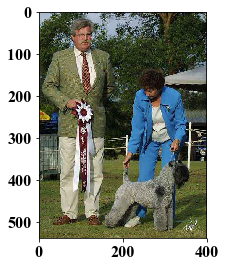

In [6]:
skimage.io.imshow(img_name)

In [7]:
faces, gray_img = image.detect_faces(img, scale=1.3, nn=2)
eye_dict = image.detect_eyes(gray_img, min_eyes=-1, scale=1.1, nn=1)
real_faces = eye_dict.keys()

In [8]:
def draw_faces(img, faces):
    img_ = img.copy()
    for (x,y,w,h) in faces:
        img_ = cv2.rectangle(img_,(x,y),(x+w,y+h),(255,0,0),2)
    return img_
    
def draw_eyes(img, eye_dict):
    # :eye_dict :: {face: eyes} :: {(x,y,w,h): list (x,y,w,h)}
    img_ = img.copy()
    # https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html#face-detection
    for (x,y,w,h),eyes in eye_dict:
        roi_gray = gray[y:y+h, x:x+w]
        for (ex,ey,ew,eh) in eyes:
            # (mutable data...)
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            
    return img_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


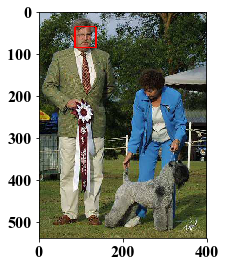

In [9]:
# (optional)
img_ = draw_faces(img, faces)
img_ = draw_eyes(img_, eye_dict)
# real_faces = draw_rectangles(img,faces,min_eyes=-1)
skimage.io.imshow(img_)

## Remove faces from img

In [10]:
# some img mutation functions

def replace(v1,v2):
    return v2

def add(v1,v2):
    # mean of r,g,b
    return np.mean([v1,v2] ,axis=0)
    # return v1 + np.minimum(v1, v2) / 2

def overlay(v1,v2):
    # add smallest element values
    intermediate = np.minimum(v1, v2)
    return v1 + intermediate # np.minimum(v1,v2)

# def sample_from_matrix(m):
#     # m :: 2d matrix
#     x = np.random.randint(0,m.shape[1] - 1)
#     y = np.random.randint(0,m.shape[0] - 1)
#     print('sampl m',x,y)
#     return m[y,x]

def sample_from_img(img):
    # return a random pixel (either rgb or bw)
    x = np.random.randint(0,img.shape[1] - 1)
    y = np.random.randint(0,img.shape[0] - 1)
    #     r = img[:,:,0]
    #     g = img[:,:,1]
    #     b = img[:,:,2]
    return img[y,x]


def random_img(dims=(10,10,3)):
    return np.random.randint(0,255,size=dims,dtype=np.uint8)


def add_img(img,img2,x,y,f=replace):
    # np index: [y][x]
    max_y, max_x = img.shape[0:2]
    h,w = img2.shape[0:2]
    xs = np.clip(np.arange(x,x + w), 0, max_x - 1)
    ys = np.clip(np.arange(y,y + h), 0, max_y -1)
    print('sha',img.shape)
    for i,x in enumerate(xs): 
        for j,y in enumerate(ys):
            # y is the first index
            img[y,x] = f(img[y,x],img2[j,i])

    return img

def add_noise(img,x,y,w,h,f=replace):
    # np index: [y][x]
    max_y, max_x = img.shape[0:2]
    xs = np.clip(np.arange(x,x + w), 0, max_x - 1)
    ys = np.clip(np.arange(y,y + h), 0, max_y -1)
    for x in xs: 
        for y in ys:
            # y is the first index
            img[y,x] = f(img)

    return img

# def convert_coordinates(x,y,w,h,shape):
#     w,h = shape[0:2]
#     y = h - y
#     return x,y

In [11]:
def scale_vector(x, w, scale=1., max_range=1):
    # scale & center a 1-dimensional vector (not cartesian-like),
    # vector: [x, x + dx]
    delta = (w * scale)- w
    x -= int(round(delta/2.))
    w += delta # w + delta/2 + delta/2
    (x,w) = np.clip([x,w], 0, max_range)
    return int(round(x)), int(round(w))

def extend_coordinates(x,y,w,h,img=[[]],scale=1.0,lower=1.0):
    # selection is a rectangle that starts at x,y with dims w,h
    # increase selection while preserving aspect ratio
    # increase d-width, d-height
    (x, w) = scale_vector(x,w,scale,img.shape[1])
    (y, h) = scale_vector(y,h,scale,img.shape[0])    
    
    # increase the bottom of the selection
    # this can be used to remove human-bodies from imgs
    h = int(round(h * lower))

    return x,y,w,h

In [12]:
# for every img

for (x,y,w,h) in faces:
    print('f',x,y,w,h)
    (x,y,w,h) = extend_coordinates(x,y,w,h,img,scale=1.5,lower=3)
    print(x,y,w,h)
    # dims = (w,h,3) # rgb = 3
    # censoring_box = random_img(dims)
    # img = add_random(img,replace,dims)
    # note that the added noise is sampled 'pre'
    # f = sample_from_img # this is a function
    img = add_noise(img,x,y,w,h,sample_from_img)

f 85 37 50 50
73 25 75 225


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


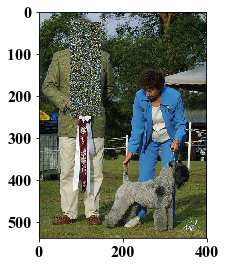

In [13]:
skimage.io.imshow(img)

In [14]:
img.shape

(539, 400, 3)

In [15]:
(img[0][0:3])

array([[166, 182, 198],
       [166, 182, 198],
       [166, 182, 198]], dtype=uint8)

In [16]:
# y,x = 0,0 is the uppermost-rightmost corner
a = np.arange(9)
a = a.reshape(3,3)
a

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [17]:
a[2][0]

6

In [18]:
a.copy()

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])